In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [2]:
model = keras.Sequential([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                            keras.layers.Dense(10, activation="relu"),
                            keras.layers.Dense(3)])

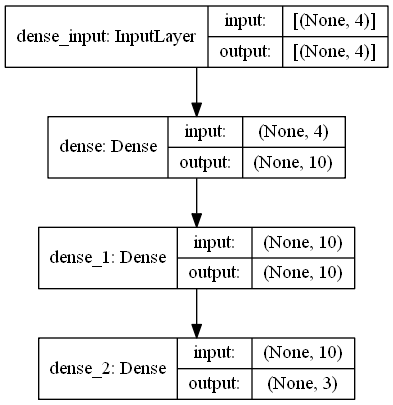

In [3]:
keras.utils.plot_model(model, show_shapes=True)

In [3]:
import os

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)

In [4]:
y = np.concatenate([y for x, y in train_dataset], axis=0)
x = np.concatenate([x for x, y in train_dataset], axis=0)

In [5]:
from evolvepy.integrations.tf_keras import TFKerasEvaluator, LossFitnessFunction

In [6]:
fitness_function = LossFitnessFunction(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), x=x, y=y)
evaluator = TFKerasEvaluator(model, fitness_function)


In [7]:
import evolvepy as ep

first = ep.generator.Layer()
mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.0, (-0.1, 0.1))
combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
filter0 = ep.generator.FilterFirsts(95)
sort = ep.generator.Sort()
filter1 = ep.generator.FilterFirsts(5)
concat = ep.generator.Concatenate()

first.next = mutation
mutation.next = combine
combine.next = filter0
filter0.next = concat

first.next = sort
sort.next = filter1
filter1.next = concat

generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=evaluator.descriptor)


In [13]:
mem_log = ep.callbacks.MemoryStoreLogger()

evolver = ep.Evolver(generator, evaluator, 100, mem_log)

In [14]:
hist, last_pop = evolver.evolve(200)

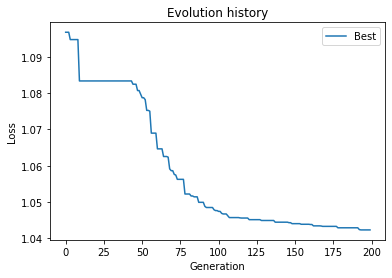

In [15]:
import matplotlib.pyplot as plt

plt.plot(-hist.max(axis=1))
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Evolution history")
plt.legend(["Best"])
plt.show()

In [74]:
true = np.array([[0,0,1]])
predict = model.predict([[0,1,2,3]])

In [91]:
features, labels = next(iter(train_dataset))

predict = model.predict(features)

In [66]:
true.shape

(1, 3)

In [60]:
predict.shape

(1, 3)

In [94]:
loss(y_true=labels, y_pred=predict)

<tf.Tensor: shape=(), dtype=float32, numpy=1.168009>

In [140]:
chromossome_sizes = []
chromossome_ranges = []
types = []
names = []

for weights in model.weights:
    chromossome_sizes.append(weights.shape.num_elements())
    chromossome_ranges.append((-1.0, 1.0))
    types.append(np.float32)
    names.append(weights.name)

from evolvepy.generator import Descriptor

descriptor = Descriptor(chromossome_sizes, chromossome_ranges, types, names)

In [141]:
descriptor._chromossome_sizes

array([ 40,  10, 100,  10,  30,   3])

In [123]:
import matplotlib.pyplot as plt

min = []
max = []

for weights in model.weights:
    min.append(np.min(weights))
    max.append(np.max(weights))

max

[0.6509609, 0.0, 0.54570127, 0.0, 0.6765835, 0.0]

In [ ]:
model.copy